<a href="https://colab.research.google.com/github/R3gm/InsightSolver-Colab/blob/main/SAHI_and_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAHI and Detectron2



SAHI is a lightweight vision library for object detection and instance segmentation. It addresses challenges like small object detection and large image inference. It offers utilities for sliced/standard predictions using various models (yolov5/mmdet/detectron2/huggingface), COCO dataset operations, and evaluation.

| Code Credits | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/obss/sahi?style=social)](https://github.com/obss/sahi) |
|Official tutorial notebooks|[SAHI Tutorials](https://github.com/obss/sahi#tutorials)|
| Original Colab | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_detectron2.ipynb) |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/InsightSolver-Colab/) |

## 0. Preparation

- Install latest version of SAHI and Detectron2:

In [ ]:
!pip install -U sahi
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.10/index.html # for Detectron2-cpu
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html # for Detectron2-cuda11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=af0876db2d408974f63c438f5fb0387a097b482be96858d855940e9e58b9a8b8
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Attempting uninstall: click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.10/index.htm

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=9e391f13943b2eeb2137ea09bcd9108753dec3e630f5a73673b39d59a21cc694
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
import os
os.getcwd()

'/content'

- Import required modules:

In [ ]:
# will be used for detectron2 fasterrcnn model zoo name
from sahi.utils.detectron2 import Detectron2TestConstants

# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image

In [ ]:
# set detectron2 fasterrcnn model zoo name
model_path = Detectron2TestConstants.FASTERCNN_MODEL_ZOO_NAME

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a Detectron2 Model

- Instantiate a detection model by defining model weight path, confing path and other parameters:

In [ ]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='detectron2',
    model_path=model_path,
    config_path=model_path,
    confidence_threshold=0.5,
    image_size=640,
    device="cpu", # or 'cuda:0'
)

model_final_280758.pkl: 167MB [00:00, 186MB/s]                           


- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [ ]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [ ]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

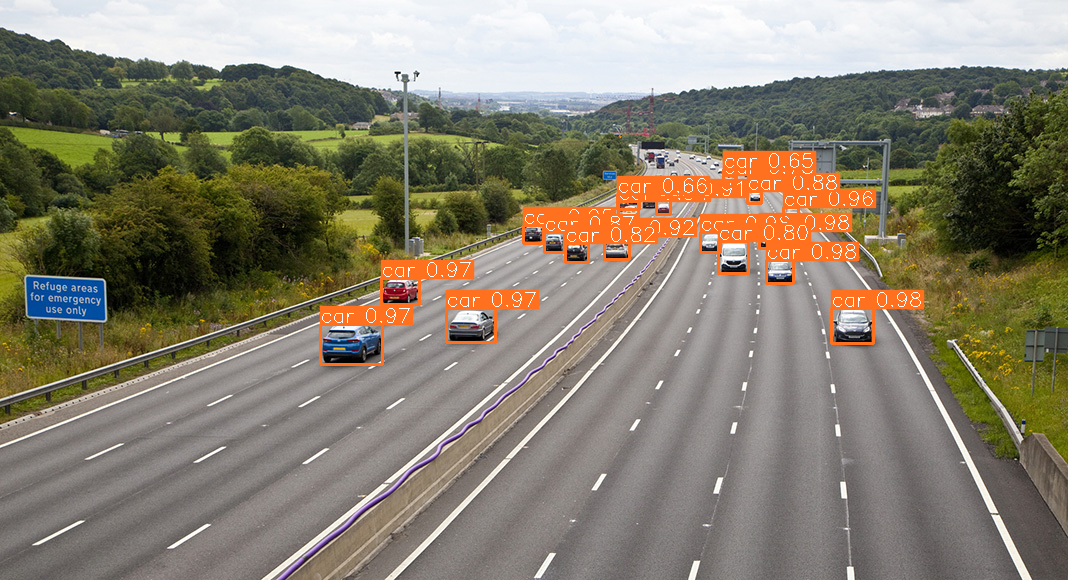

In [ ]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a Detectron2 Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.2:

In [ ]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

Performing prediction on 15 number of slices.


- Visualize predicted bounding boxes and masks over the original image:

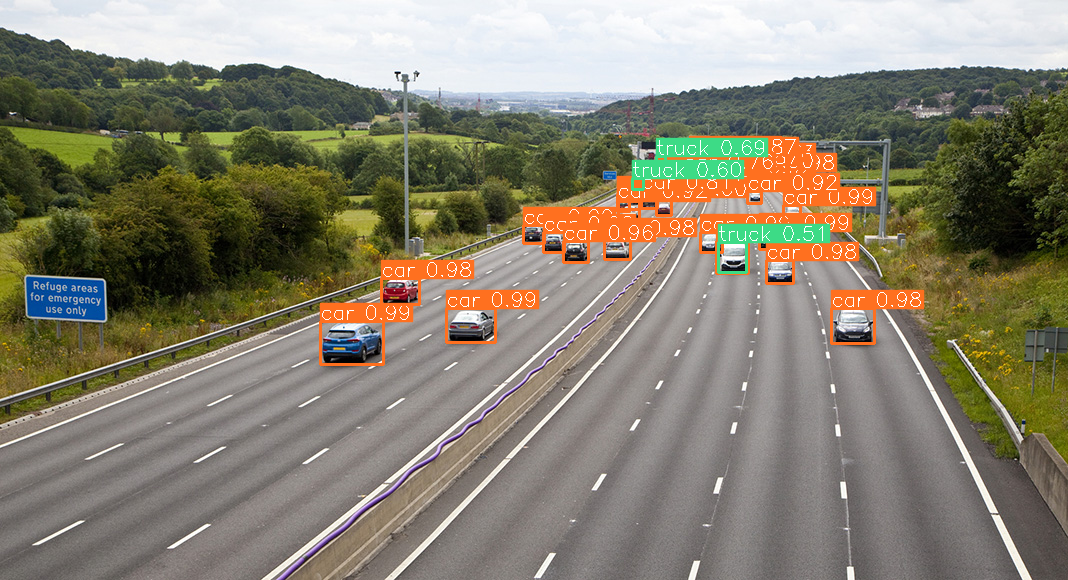

In [ ]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [ ]:
object_prediction_list = result.object_prediction_list

In [ ]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(656.2901611328125, 197.37916564941406, 671.897632598877, 215.30213451385498), w: 15.607471466064453, h: 17.922968864440918>,
    mask: None,
    score: PredictionScore: <value: 0.9950494170188904>,
    category: Category: <id: 2, name: car>>

In [ ]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [656.2901611328125,
   197.37916564941406,
   15.607471466064453,
   17.922968864440918],
  'score': 0.9950494170188904,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 279},
 {'image_id': None,
  'bbox': [446.5525207519531,
   308.10736083984375,
   48.657371520996094,
   34.387939453125],
  'score': 0.9942395687103271,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1673},
 {'image_id': None,
  'bbox': [759.7645263671875,
   231.37075233459473,
   21.563888549804688,
   18.118703842163086],
  'score': 0.9921349287033081,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 390}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [ ]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [656.2901611328125,
   197.37916564941406,
   15.607471466064453,
   17.922968864440918],
  'score': 0.9950494170188904,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 279},
 {'image_id': 1,
  'bbox': [446.5525207519531,
   308.10736083984375,
   48.657371520996094,
   34.387939453125],
  'score': 0.9942395687103271,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1673},
 {'image_id': 1,
  'bbox': [759.7645263671875,
   231.37075233459473,
   21.563888549804688,
   18.118703842163086],
  'score': 0.9921349287033081,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 390}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [ ]:
!pip install -U imantics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16030 sha256=186190ec50e28f965011b14278f2ab01acf29645e322e8793cac742ab93817af
  Stored in directory: /root/.cache/pip/wheels/56/6a/be/4c60e88b14abec4e93234a1f7f91ce8abe1ae88a2b3eaad3ac
Successfully built imantics


In [ ]:
result.to_imantics_annotations()[:3]

## 4. Batch Prediction

- Set model and directory parameters:

In [ ]:
model_type = "detectron2"
model_path = model_path
model_config_path = model_path
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.5

slice_height = 480
slice_width = 480
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [ ]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_config_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 6 number of slices.


Performing inference on images:  33%|███▎      | 1/3 [00:28<00:56, 28.10s/it]

Prediction time is: 28015.89 ms
Performing prediction on 6 number of slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:57<00:28, 28.65s/it]

Prediction time is: 28948.50 ms
Performing prediction on 6 number of slices.


Performing inference on images: 100%|██████████| 3/3 [01:25<00:00, 28.65s/it]

Prediction time is: 28753.57 ms
Prediction results are successfully exported to runs/predict/exp


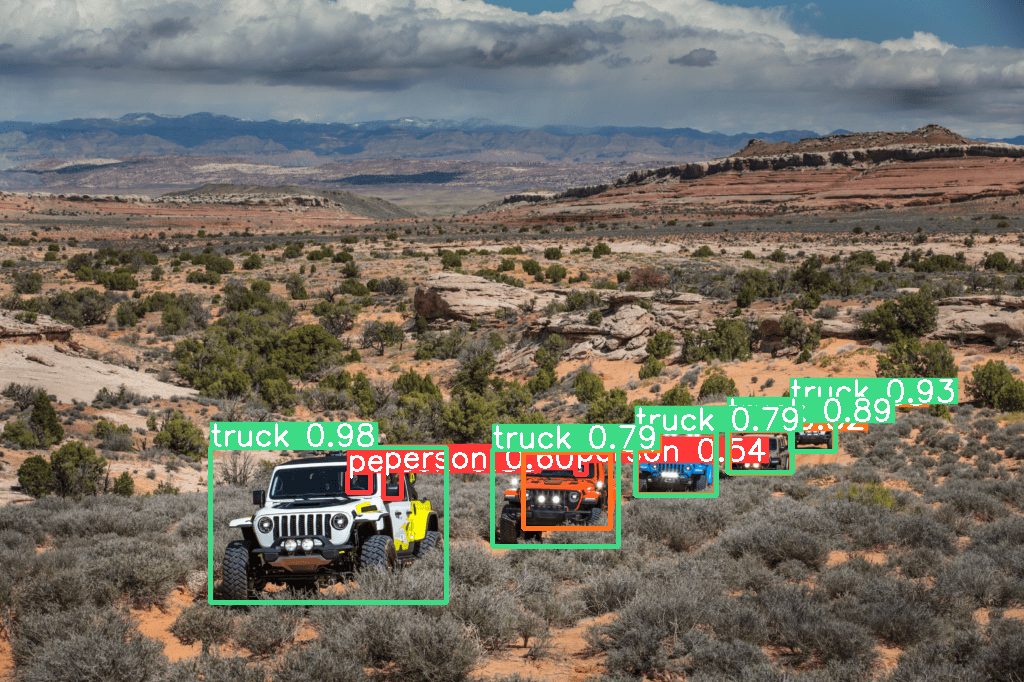

In [ ]:
Image("/content/runs/predict/exp/visuals/terrain2.png") #